# Magics

In [1]:
%load_ext autoreload

%autoreload 2

# Module Imports

In [2]:
import os
import glob
import pickle
import string
import sys
from tqdm.notebook import tqdm

sys.path.append('../')

import numpy as np
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1 import ImageGrid, make_axes_locatable, Size, Divider
import matplotlib.colors as mcolors

from Preprocessing_Methods import *
from bl_plots_new import *

from TSquared.hotelling_t2 import HotellingT2

/home/conor/miniconda3/envs/PHD/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.5.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


# Import Data

In [27]:
file_names = glob.glob('/mnt/c/Users/conor/OneDrive/Desktop/temp_extraction_new/*')

annotations = dict()

for file_name in tqdm(file_names):
    for i in [1,2]:
        try:
            annotations[f"{file_name.split('/')[-1][:-4]}"] = matplotlib.image.imread(f"/mnt/c/Users/conor/Google Drive/PHD/Project with Janet/Label_Images/TMA_{i}/{file_name.split('/')[-1][:-4]}.png")  
            continue

        except FileNotFoundError as e:

            pass
            #print(f'{file_name} not found')

In [3]:
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, FunctionTransformer, normalize

In [4]:
master = pd.read_excel('/mnt/c/Users/conor/OneDrive/Desktop/master_xl_1507.xlsx')
gb = list(master.groupby('REF'))

In [4]:
total = pd.read_pickle('./December_Datat_32.pickle')
#total = truncate(total, start=1000, end=1800)

# Cox plots

In [5]:
from sklearn.preprocessing import minmax_scale, OrdinalEncoder, OneHotEncoder
from sklearn.compose import make_column_selector, make_column_transformer

from lifelines import CoxPHFitter

In [188]:
ht2 = HotellingT2().fit(total)
#total = total.loc[ht2.predict(total)==1,:]

min_ = total.index.get_level_values('Patient_Number').value_counts().min()
sel = total#.groupby('Patient_Number').sample(min_)
sel = sel.reset_index(['ASMA']).dropna()#.sample(2000)
sel['IDX'] = np.arange(sel.shape[0])
sel = sel.set_index('IDX', append=True)

sel.columns = [str(col) for col in sel.columns]

In [123]:
def get_ct():

    num_pipe = Pipeline([
    ("Normalise spectra", FunctionTransformer(minmax_scale, kw_args = {"axis": 1})),
    ("Feature Scale", FunctionTransformer(minmax_scale, kw_args = {"axis": 0})),
    ("PCA", PCA(7)),
    ])

    cat_pipe = Pipeline([
        #("OneHot", OneHotEncoder(sparse=False, handle_unknown='ignore', dtype=int))
        ("Encoding", OrdinalEncoder(handle_unknown='error', dtype=int))
    ])

    ct = make_column_transformer(
        (num_pipe, make_column_selector(dtype_include=np.number)),
        (cat_pipe, make_column_selector(dtype_include=object))
    )

    return ct

In [124]:
for name, X_data in zip(['ASMA_FTIR', 'FTIR'], [sel, sel.iloc[:,1:]]):

    ct = get_ct()
    transformed = pd.DataFrame(ct.fit_transform(X_data), index=X_data.index)
    transformed.reset_index(['DiedvsAlive', 'survival (months)'], inplace=True)
    transformed['DiedvsAlive'] = 1*(transformed['DiedvsAlive']=='Died')
    
    cph = CoxPHFitter()
    cph.fit(transformed,
                duration_col='survival (months)', 
                event_col='DiedvsAlive')
    break

In [125]:
ct.transformers[0][1][-1].inverse_transform(cph.summary['coef'].iloc[:-1].values)

AttributeError: 'PCA' object has no attribute 'components_'

In [107]:
cph.summary['coef'].iloc[:-1].values

array([-0.01650635, -0.03788171, -0.17886013,  3.10320299,  1.61728543,
       -6.48096059, -2.58280013])

In [83]:
cph.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,z,p,-log2(p)
covariate,,,,,,,,,,
0,-0.016506,0.983629,0.004162,-0.024663,-0.008349,0.975638,0.991685,-3.966136,7.304714e-05,13.740813
1,-0.037882,0.962827,0.004481,-0.046664,-0.029100,0.954408,0.971319,-8.454545,2.801782e-17,54.986433
2,-0.178860,0.836223,0.010118,-0.198691,-0.159029,0.819803,0.852971,-17.677535,6.246832e-70,229.891842
3,3.103203,22.269165,0.011938,3.079804,3.126602,21.754142,22.796381,259.935006,0.000000e+00,inf
4,1.617285,5.039392,0.012813,1.592173,1.642398,4.914418,5.167544,126.226741,0.000000e+00,inf
5,-6.480961,0.001532,0.021870,-6.523824,-6.438097,0.001468,0.001599,-296.345499,0.000000e+00,inf
6,-2.582800,0.075562,0.025023,-2.631843,-2.533757,0.071946,0.079360,-103.218859,0.000000e+00,inf
7,-0.500297,0.606351,0.004594,-0.509301,-0.491293,0.600915,0.611835,-108.900557,0.000000e+00,inf


In [194]:
sel.index.get_level_values('2year').value_counts()

True     151408
False    113454
Name: 2year, dtype: int64

# Demographics Table

In [6]:
def range_(array):

    return f'{array.min()} - {array.max()}'


In [7]:
patients = total.groupby('Patient_Number').sample(1).reset_index().iloc[:,:44].dropna(subset=['ASMA'])

<AxesSubplot:xlabel='Opt_Group', ylabel='survival (months)'>

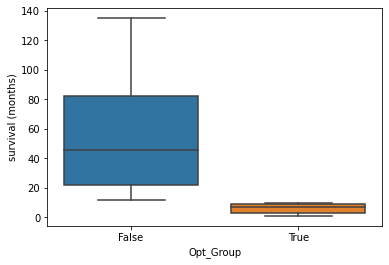

In [8]:
sns.boxplot(data=patients, y='survival (months)', x='Opt_Group')

In [19]:
tables = dict()

for marg, pred_name in zip([True, True], ['1yeardeath', '2year', 'Opt_Group']):
    #pred_name='Opt_Group'
    pred_name='2year'
    age = patients.pivot_table('age @ diag', pred_name, aggfunc=[np.mean, range_, np.median]).T
    gen = pd.crosstab(patients['gender'], patients[pred_name], margins=marg)
    T = pd.crosstab(patients['T stage'], patients[pred_name], margins=marg)
    N = pd.crosstab(patients['N stage'], patients[pred_name], margins=marg)
    Site = pd.crosstab(patients['site'], patients[pred_name], margins=marg)

    tab=pd.concat([age, gen, T, N, Site])#.to_latex(f'./Prognosis_Paper_Plots/Tables/{pred_name}_table.txt')
    break

In [20]:
patients[['Opt_Group','T stage']].value_counts().T

Opt_Group  T stage
False      2          10
           4           4
True       2           4
           4           4
False      3           2
           4a          2
True       4a          2
False      1           1
dtype: int64

In [21]:
tab#.set_index(['2year'])

2year,False,True,All
"(mean, age @ diag)",57.428571,64.533333,NaN
"(range_, age @ diag)",29 - 68,48 - 85,NaN
"(median, age @ diag)",60,64,NaN
f,5,2,7.0
m,9,13,22.0
All,14,15,29.0
1,1,0,1.0
2,6,8,14.0
3,0,2,2.0
4,5,3,8.0


In [16]:
total.index.get_level_values('Opt_Group').value_counts()

False    172969
True      96402
Name: Opt_Group, dtype: int64

In [17]:
patients['Opt_Group'].value_counts()

False    21
True     10
Name: Opt_Group, dtype: int64

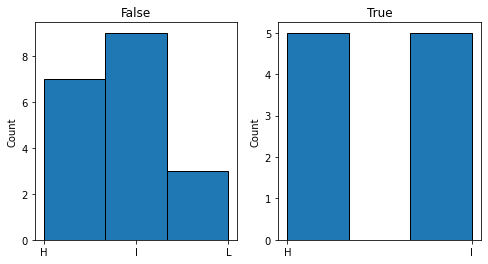

In [140]:
fig, axes = plt.subplots(ncols=2, figsize=(8,4))

for ax, (name, df) in zip(axes, patients.groupby('1yeardeath')):

    df.sort_values(by='ASMA')['ASMA'].hist(ax=ax, bins=3, edgecolor='black', grid=False, histtype='barstacked', rwidth=1.0)
    ax.set_ylabel('Count')
    ax.set_title(name)

In [156]:
patients

,Overall Death,Alive,stage,T stage,Last updated,DODvsAlive,site of recurrence,X,age @ diag,Disk,...,diff,lifespan,TMA site,ECS,REF,Opt_Group,1yeardeath,ASMA,TMA_x,gender
0,yes,False,4,4a,NaT,Other,NaN,131.0,59,TMA_1.1_B5,...,mod well,574.0,B5,yes,TMA_2_B5,True,True,I,TMA_2,m
1,yes,False,4,2,2020-04-01,Other,NaN,89.0,67,TMA_1.2_C11,...,mod,1637.0,C11,yes,TMA_1_C11,False,False,H,TMA_1,m
2,yes,False,4,4,2020-03-13,DOD,NaN,162.0,70,TMA_1.1_B1,...,mod,51.0,B1,yes,TMA_2_B1,True,True,H,TMA_2,m
3,no,False,4,4,2020-04-01,Other,NaN,208.0,61,TMA_1.2_A12,...,mod,NaN,A12,yes,TMA_1_A12,False,False,I,TMA_1,f
4,yes,False,4,2,2012-10-04,DOD,metastases,110.0,48,TMA_1.1_A2,...,mod,497.0,A2,no,TMA_2_A2,False,False,I,TMA_2,f
5,no,False,4a,4a,2020-05-11,Other,local,187.0,56,TMA_1.2_D10,...,mod,NaN,D10,no,TMA_1_D10,False,False,I,TMA_1,f
6,yes,False,4a,2,2019-05-16,Other,NaN,81.0,58,TMA_1.1_C1,...,mod,998.0,C1,yes,TMA_2_C1,False,False,I,TMA_2,m
7,no,False,4a,4,2020-04-01,Other,lung mets,225.0,59,TMA_1.2_A10,...,mod,NaN,A10,yes,TMA_1_A10,False,False,I,TMA_1,m
8,yes,False,4a,4,2011-08-04,DOD,regional,105.0,64,TMA_1.1_C6,...,well,192.0,C6,yes,TMA_1_C6,True,True,I,TMA_1,m
9,yes,False,4a,2,2012-10-04,DOD,NaN,138.0,52,TMA_1.2_C12,...,mod,615.0,C12,yes,TMA_1_C12,False,False,H,TMA_1,m


In [152]:
patients[['Patient_Number', 'ASMA']]

,Patient_Number,ASMA
0,3237,I
1,3248,H
2,3251,H
3,3252,I
4,3254,I
5,3261,I
6,3270,I
7,3271,I
8,3285,I
9,3286,H


In [143]:
pd.crosstab(index=[patients['Opt_Group'], patients['ASMA']]
, columns='Patient_Number'
, aggfunc=len
, values=patients['Opt_Group']
, margins=True).iloc[:-1,:].T

Opt_Group      False       True   
ASMA               H  I  L    H  I
col_0                             
Patient_Number     7  9  3    5  5
All                7  9  3    5  5

patients[['site','Patient_nu ']].reset_index(drop=True).to_excel('./Prognosis_Paper_Plots/patient_list_for_janet.xlsx')

# Annotation Plots

TMA_1_D5


/tmp/ipykernel_3184/4049445331.py:14: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.subplots_adjust(wspace=0)


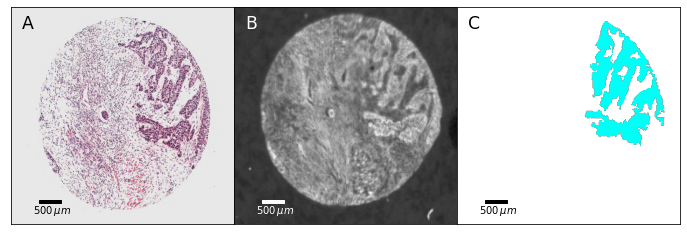

In [81]:
row = gb[29]

name = row[0]
print(name)

df1 = row[1].iloc[0,:]

ftir = pd.read_hdf(df1['FTIR'], key='Data')
ann = matplotlib.image.imread(df1['ANN'])
he1 = matplotlib.image.imread(df1['HE'])


fig, axes = plt.subplots(ncols=3, figsize=(12,4), constrained_layout = True)
fig.subplots_adjust(wspace=0)
[(ax.set_xticks([]), ax.set_yticks([])) for ax in axes];


sbx, sby = 0.1, 0.05
sb = 500

axes[0].imshow(he1,aspect='auto')
axes[0].text(0.05, 0.9, 'A', size='xx-large', transform=axes[0].transAxes)
axes[0].add_patch(Rectangle((sbx+0.025, 0.1), 0.1, 0.01, color='black', transform=axes[0].transAxes))
axes[0].text(sbx, sby, f'${sb}\/\mu m$', size='medium', transform=axes[0].transAxes)


axes[1].imshow(ftir.values.reshape(256,256,-1)[10:-15,:,195],aspect='auto', cmap='gray')
axes[1].text(0.05, 0.9, 'B', size='xx-large', color='w', transform=axes[1].transAxes)
axes[1].add_patch(Rectangle((sbx+0.025, 0.1), 0.1, 0.01, color='w', transform=axes[1].transAxes))
axes[1].text(sbx, sby, f'${sb}\/\mu m$', size='medium', color='w', transform=axes[1].transAxes)


axes[2].imshow(ann[10:-15,:,:],aspect='auto')
axes[2].text(0.05, 0.9, 'C', size='xx-large', transform=axes[2].transAxes)
axes[2].add_patch(Rectangle((sbx+0.025, 0.1), 0.1, 0.01, color='black', transform=axes[2].transAxes))
axes[2].text(sbx, sby, f'${sb}\/\mu m$', size='medium', transform=axes[2].transAxes)


fig.savefig('./Prognosis_Paper_Plots/Annotation.pdf', bbox_inches='tight')

# ROC Curves

In [3]:
names = ['1yd_ASMA', '1yd_no_ASMA','2yd_ASMA', '2yd_no_ASMA']

filt_dicts = dict()
unfilt_dicts = dict()

for filt_type, result_dict in zip(['Filtered', 'Unfiltered'], [filt_dicts, unfilt_dicts]):

    folder = f'/mnt/c/Users/conor/Git_Projects/PHD/Prognosis_Results/bare_results/{filt_type}/*.pickle'

    file_names = glob.glob(folder)

    for name, fn in zip(names, file_names):

        with open(fn, 'rb') as file:

            result_dict[name] = pickle.load(file)


joined_sets = pd.concat({k: pd.DataFrame(v['Normal LR']['Stats']) for k, v in unfilt_dicts.items()})#.groupby(level=0).hist()
joined_sets.index.set_names(['Set', 'Sample'], [0,1], inplace=True)

<ipython-input-66-444831642ff5>:2: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.subplots_adjust(wspace=0)


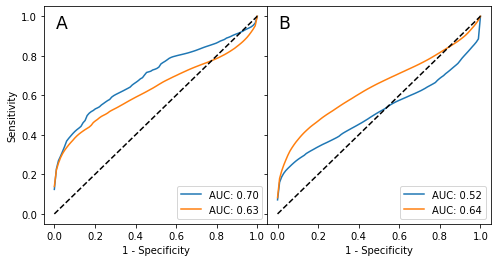

In [66]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8,4), sharey=True, constrained_layout = True)
fig.subplots_adjust(wspace=0)

x = np.linspace(0,1,100)

auc1 = np.mean(unfilt_dicts['1yd_ASMA']['Normal LR']['Stats']['AUC'])
ax1.plot(x, unfilt_dicts['1yd_ASMA']['Normal LR']['ROC Curves'].mean(axis=0), label=f'AUC: {auc1:0.2f}')

auc2 = np.mean(unfilt_dicts['1yd_no_ASMA']['Normal LR']['Stats']['AUC'])
ax1.plot(x, unfilt_dicts['1yd_no_ASMA']['Normal LR']['ROC Curves'].mean(axis=0), label=f'AUC: {auc2:0.2f}')

ax1.plot([0,1],[0,1], ls='--', c='black')
ax1.set_xlabel('1 - Specificity')
ax1.set_ylabel('Sensitivity')
ax1.text(0.05, 0.9, 'A', size='xx-large', transform=ax1.transAxes)
ax1.legend(loc=4)

# ------------------------------------------------------------------------------------------------------------

auc3 = np.mean(unfilt_dicts['2yd_ASMA']['Normal LR']['Stats']['AUC'])
ax2.plot(x, unfilt_dicts['2yd_ASMA']['Normal LR']['ROC Curves'].mean(axis=0), label=f'AUC: {auc3:0.2f}')

auc4 = np.mean(unfilt_dicts['2yd_no_ASMA']['Normal LR']['Stats']['AUC'])
ax2.plot(x, unfilt_dicts['2yd_no_ASMA']['Normal LR']['ROC Curves'].mean(axis=0), label=f'AUC: {auc4:0.2f}')

ax2.plot([0,1],[0,1], ls='--', c='black')
ax2.set_xlabel('1 - Specificity')
ax2.text(0.05, 0.9, 'B', size='xx-large', transform=ax2.transAxes)
ax2.legend(loc=4)

fig.savefig('./Prognosis_Paper_Plots/ROC_Curves.pdf', bbox_inches='tight')

# Precision Recall Curves

<ipython-input-67-331ad99b125b>:2: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.subplots_adjust(wspace=0)


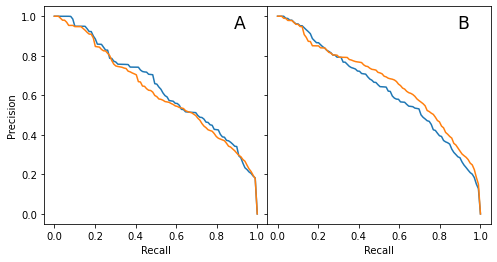

In [67]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8,4), sharey=True, constrained_layout = True)
fig.subplots_adjust(wspace=0)

x = np.linspace(0,1,100)

auc1 = np.mean(unfilt_dicts['1yd_ASMA']['Normal LR']['Stats']['AUC'])
ax1.plot(x, unfilt_dicts['1yd_ASMA']['Normal LR']['PR Curves'].mean(axis=0))

auc2 = np.mean(unfilt_dicts['1yd_no_ASMA']['Normal LR']['Stats']['AUC'])
ax1.plot(x, unfilt_dicts['1yd_no_ASMA']['Normal LR']['PR Curves'].mean(axis=0))

ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.text(0.85, 0.9, 'A', size='xx-large', transform=ax1.transAxes)

# ------------------------------------------------------------------------------------------------------------

auc3 = np.mean(unfilt_dicts['2yd_ASMA']['Normal LR']['Stats']['AUC'])
ax2.plot(x, unfilt_dicts['2yd_ASMA']['Normal LR']['PR Curves'].mean(axis=0))

auc4 = np.mean(unfilt_dicts['2yd_no_ASMA']['Normal LR']['Stats']['AUC'])
ax2.plot(x, unfilt_dicts['2yd_no_ASMA']['Normal LR']['PR Curves'].mean(axis=0))

ax2.set_xlabel('Recall')
ax2.text(0.85, 0.9, 'B', size='xx-large', transform=ax2.transAxes)

fig.savefig('./Prognosis_Paper_Plots/PR_Curves.pdf', bbox_inches='tight')

# Stats Plots

## 1 year death

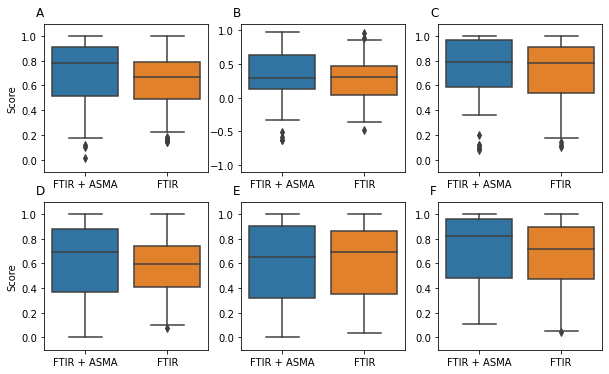

In [142]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(10,6))
fig.subplots_adjust(wspace=0.2)

for ax, name, let in zip(axes.flatten(), joined_sets.columns, string.ascii_uppercase):
    ax = sns.boxplot(data=joined_sets.query('Set in ["1yd_ASMA", "1yd_no_ASMA"]').reset_index()
    , x='Set'
    , y=name
    , ax=ax
    , whis=1)
    ax.set_xticklabels(['FTIR + ASMA', 'FTIR'])
    ax.set_xlabel(None)
    
    if let in ['A', 'D']:
        ax.set_ylabel('Score')
    else:
        ax.set_ylabel(None)


    if let == 'B':
        ax.set_ylim(-1.1,1.1)
    
    else:
        ax.set_ylim(-0.1,1.1)

    ax.text(-0.05, 1.05, let, size='large', transform=ax.transAxes)


fig.savefig('./Prognosis_Paper_Plots/Stats_Plots/Stats_Plot_1yeardeath.pdf', bbox_inches='tight')

## 2 year death

In [69]:
list(zip(joined_sets.columns, string.ascii_uppercase))

[('AUC', 'A'),
 ('MCC', 'B'),
 ('Specificity', 'C'),
 ('Sensitivity', 'D'),
 ('PPV', 'E'),
 ('NPV', 'F')]

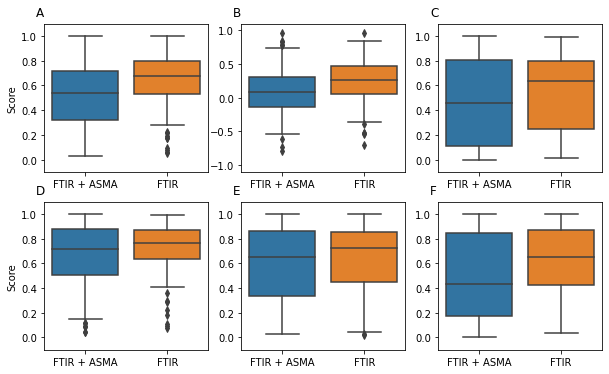

In [143]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(10,6))
fig.subplots_adjust(wspace=0.2)

for ax, name, let in zip(axes.flatten(), joined_sets.columns, string.ascii_uppercase):
    ax = sns.boxplot(data=joined_sets.query('Set in ["2yd_ASMA", "2yd_no_ASMA"]').reset_index()
    , x='Set'
    , y=name
    , ax=ax
    , whis=1)
    ax.set_xticklabels(['FTIR + ASMA', 'FTIR'])
    ax.set_xlabel(None)
    
    if let in ['A', 'D']:
        ax.set_ylabel('Score')
    else:
        ax.set_ylabel(None)


    if let == 'B':
        ax.set_ylim(-1.1,1.1)
    
    else:
        ax.set_ylim(-0.1,1.1)

    ax.text(-0.05, 1.05, let, size='large', transform=ax.transAxes)

fig.savefig('./Prognosis_Paper_Plots/Stats_Plots/Stats_Plot_2yeardeath.pdf', bbox_inches='tight')

# ROC + PR

## 1 year death

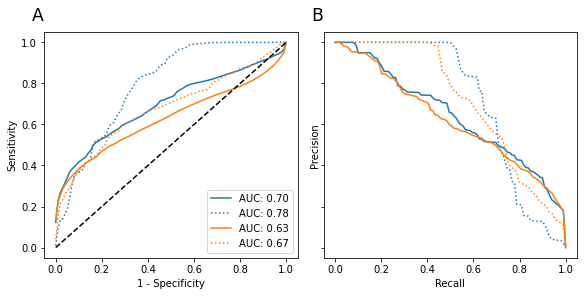

In [119]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8,4), sharey=True, constrained_layout = True)

x = np.linspace(0,1,100)

c1, c2 = 'tab:blue' , 'tab:orange'

# mean ASMA ROC
auc1 = np.mean(unfilt_dicts['1yd_ASMA']['Normal LR']['Stats']['AUC'])
ax1.plot(x, unfilt_dicts['1yd_ASMA']['Normal LR']['ROC Curves'].mean(axis=0), label=f'AUC: {auc1:0.2f}', c=c1)

# median ASMA ROC
auc1 = np.median(unfilt_dicts['1yd_ASMA']['Normal LR']['Stats']['AUC'])
ax1.plot(x, np.median(unfilt_dicts['1yd_ASMA']['Normal LR']['ROC Curves'],axis=0), label=f'AUC: {auc1:0.2f}', ls=':', c=c1)

# mean noASMA ROC
auc2 = np.mean(unfilt_dicts['1yd_no_ASMA']['Normal LR']['Stats']['AUC'])
ax1.plot(x, unfilt_dicts['1yd_no_ASMA']['Normal LR']['ROC Curves'].mean(axis=0), label=f'AUC: {auc2:0.2f}', c=c2)

# median noASMA ROC
auc2 = np.median(unfilt_dicts['1yd_no_ASMA']['Normal LR']['Stats']['AUC'])
ax1.plot(x, np.median(unfilt_dicts['1yd_no_ASMA']['Normal LR']['ROC Curves'],axis=0), label=f'AUC: {auc2:0.2f}', ls=':', c=c2)

ax1.plot([0,1],[0,1], ls='--', c='black')
ax1.set_xlabel('1 - Specificity')
ax1.set_ylabel('Sensitivity')
ax1.text(-0.05, 1.05, 'A', size='xx-large', transform=ax1.transAxes)
ax1.legend(loc=4)

# ------------------------------------------------------------------------------------------------------------

auc3 = np.mean(unfilt_dicts['1yd_ASMA']['Normal LR']['Stats']['AUC'])
ax2.plot(x, unfilt_dicts['1yd_ASMA']['Normal LR']['PR Curves'].mean(axis=0), c=c1)

auc3 = np.mean(unfilt_dicts['1yd_ASMA']['Normal LR']['Stats']['AUC'])
ax2.plot(x, np.median(unfilt_dicts['1yd_ASMA']['Normal LR']['PR Curves'], axis=0), ls=':', c=c1)

auc4 = np.mean(unfilt_dicts['1yd_no_ASMA']['Normal LR']['Stats']['AUC'])
ax2.plot(x, unfilt_dicts['1yd_no_ASMA']['Normal LR']['PR Curves'].mean(axis=0), c=c2)


ax2.plot(x, np.median(unfilt_dicts['1yd_no_ASMA']['Normal LR']['PR Curves'], axis=0), ls=':', c=c2)


ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.text(-0.05, 1.05, 'B', size='xx-large', transform=ax2.transAxes)
fig.savefig('./Prognosis_Paper_Plots/ROC_PR_Curves/1yeardeath.pdf', bbox_inches='tight')

## 2 year death

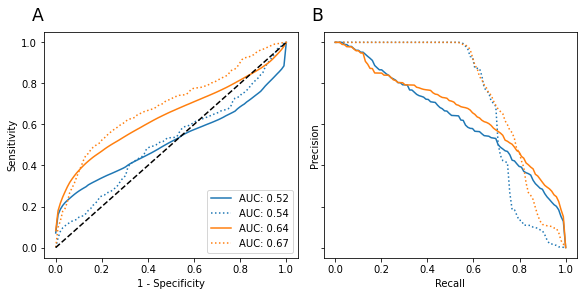

In [118]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8,4), sharey=True, constrained_layout = True)

x = np.linspace(0,1,100)

c1, c2 = 'tab:blue' , 'tab:orange'

# mean ASMA ROC
auc1 = np.mean(unfilt_dicts['2yd_ASMA']['Normal LR']['Stats']['AUC'])
ax1.plot(x, unfilt_dicts['2yd_ASMA']['Normal LR']['ROC Curves'].mean(axis=0), label=f'AUC: {auc1:0.2f}', c=c1)

# median ASMA ROC
auc1 = np.median(unfilt_dicts['2yd_ASMA']['Normal LR']['Stats']['AUC'])
ax1.plot(x, np.median(unfilt_dicts['2yd_ASMA']['Normal LR']['ROC Curves'],axis=0), label=f'AUC: {auc1:0.2f}', ls=':', c=c1)

# mean noASMA ROC
auc2 = np.mean(unfilt_dicts['2yd_no_ASMA']['Normal LR']['Stats']['AUC'])
ax1.plot(x, unfilt_dicts['2yd_no_ASMA']['Normal LR']['ROC Curves'].mean(axis=0), label=f'AUC: {auc2:0.2f}', c=c2)

# median noASMA ROC
auc2 = np.median(unfilt_dicts['2yd_no_ASMA']['Normal LR']['Stats']['AUC'])
ax1.plot(x, np.median(unfilt_dicts['2yd_no_ASMA']['Normal LR']['ROC Curves'],axis=0), label=f'AUC: {auc2:0.2f}', ls=':', c=c2)

ax1.plot([0,1],[0,1], ls='--', c='black')
ax1.set_xlabel('1 - Specificity')
ax1.set_ylabel('Sensitivity')
ax1.text(-0.05, 1.05, 'A', size='xx-large', transform=ax1.transAxes)
ax1.legend(loc=4)

# ------------------------------------------------------------------------------------------------------------

auc3 = np.mean(unfilt_dicts['2yd_ASMA']['Normal LR']['Stats']['AUC'])
ax2.plot(x, unfilt_dicts['2yd_ASMA']['Normal LR']['PR Curves'].mean(axis=0), c=c1)

auc3 = np.mean(unfilt_dicts['2yd_ASMA']['Normal LR']['Stats']['AUC'])
ax2.plot(x, np.median(unfilt_dicts['2yd_ASMA']['Normal LR']['PR Curves'], axis=0), ls=':', c=c1)

auc4 = np.mean(unfilt_dicts['2yd_no_ASMA']['Normal LR']['Stats']['AUC'])
ax2.plot(x, unfilt_dicts['2yd_no_ASMA']['Normal LR']['PR Curves'].mean(axis=0), c=c2)


ax2.plot(x, np.median(unfilt_dicts['2yd_no_ASMA']['Normal LR']['PR Curves'], axis=0), ls=':', c=c2)


ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.text(-0.05, 1.05, 'B', size='xx-large', transform=ax2.transAxes)
fig.savefig('./Prognosis_Paper_Plots/ROC_PR_Curves/2yeardeath.pdf', bbox_inches='tight')

# Survival Analysis

## 1 year death

## Joined

0.000
0.009


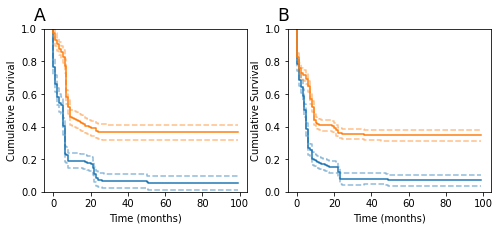

In [115]:
fig, axes = plt.subplots(ncols=2, figsize=(8,3))
fig.subplots_adjust(wspace=0.2)

cs = ['tab:green', 'tab:red']

for ax, subset, let in zip(axes.flatten(), ['1yd_ASMA', '1yd_no_ASMA'], string.ascii_uppercase, cs):

    surv_dict = unfilt_dicts[subset]['Normal LR']
    km_plots(surv_dict['TSI'], surv_dict['FSI'], axin=ax, ste=True, median=True, );
    ax.text(-0.05, 1.05, let, size='xx-large', transform=ax.transAxes)

    p_m = np.array(surv_dict['Survival_P'])[:,1].mean()
    p_std = np.array(surv_dict['Survival_P'])[:,1].std()
    print(f'{p_m:0.3f}')

fig.savefig('./Prognosis_Paper_Plots/Survival/1yeardeath_Joined.pdf', bbox_inches='tight')
#fig.axes[0].text(0.80, 0.90, f'{p_m:0.7f}', size='x-large', transform=fig.axes[0].transAxes)

### ASMA

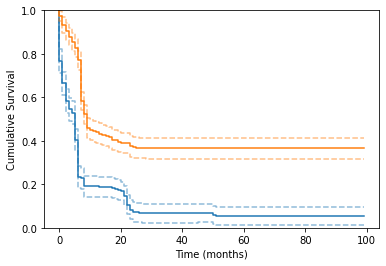

In [114]:
surv_dict = unfilt_dicts['1yd_ASMA']['Normal LR']

fig1 = km_plots(surv_dict['TSI'], surv_dict['FSI'], ste=True, median=True);

p_m = np.array(surv_dict['Survival_P'])[:,1].mean()
p_std = np.array(surv_dict['Survival_P'])[:,1].std()
fig.savefig('./Prognosis_Paper_Plots/Survival/1yeardeath_ASMA.pdf', bbox_inches='tight')
#fig.axes[0].text(0.80, 0.90, f'{p_m:0.7f}', size='x-large', transform=fig.axes[0].transAxes)

### No ASMA

AttributeError: 'AxesSubplot' object has no attribute 'savefig'

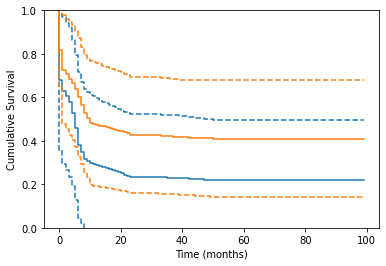

In [ ]:
### ASMA
surv_dict = unfilt_dicts['1yd_no_ASMA']['Normal LR']

fig = km_plots(surv_dict['TSI'], surv_dict['FSI']);

p_m = np.array(surv_dict['Survival_P'])[:,1].mean()
p_std = np.array(surv_dict['Survival_P'])[:,1].std()
fig.savefig('./Prognosis_Paper_Plots/Survival/1yeardeath_no_ASMA.pdf', bbox_inches='tight')

#fig.axes[0].text(0.80, 0.90, f'{p_m:0.7f}', size='x-large', transform=fig.axes[0].transAxes)

## 2 year death

## Joined

0.000
0.003


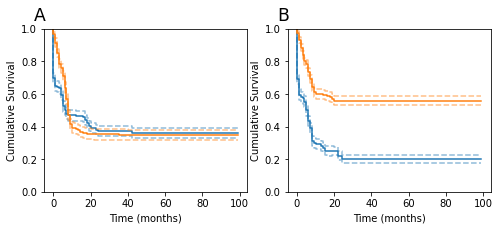

In [116]:
fig, axes = plt.subplots(ncols=2, figsize=(8,3))
fig.subplots_adjust(wspace=0.2)

for ax, subset, let in zip(axes.flatten(), ['2yd_ASMA', '2yd_no_ASMA'], string.ascii_uppercase):

    surv_dict = unfilt_dicts[subset]['Normal LR']
    km_plots(surv_dict['TSI'], surv_dict['FSI'], axin=ax,ste=True, median=True);
    ax.text(-0.05, 1.05, let, size='xx-large', transform=ax.transAxes)

    p_m = np.array(surv_dict['Survival_P'])[:,1].mean()
    p_std = np.array(surv_dict['Survival_P'])[:,1].std()
    print(f'{p_m:0.3f}')

fig.savefig('./Prognosis_Paper_Plots/Survival/2yeardeath_Joined.pdf', bbox_inches='tight')
#fig.axes[0].text(0.80, 0.90, f'{p_m:0.7f}', size='x-large', transform=fig.axes[0].transAxes)

### ASMA

AttributeError: 'AxesSubplot' object has no attribute 'savefig'

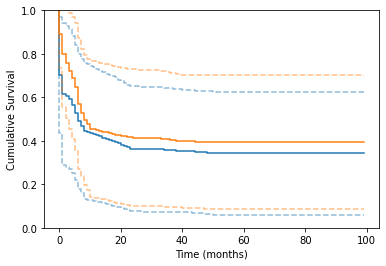

In [98]:
surv_dict = unfilt_dicts['2yd_ASMA']['Normal LR']

fig = km_plots(surv_dict['TSI'], surv_dict['FSI']);

p_m = np.array(surv_dict['Survival_P'])[:,1].mean()
p_std = np.array(surv_dict['Survival_P'])[:,1].std()
fig.savefig('./Prognosis_Paper_Plots/Survival/2yeardeath_ASMA.pdf', bbox_inches='tight')

#fig.axes[0].text(0.80, 0.90, f'{p_m:0.7f}', size='x-large', transform=fig.axes[0].transAxes)

### No ASMA

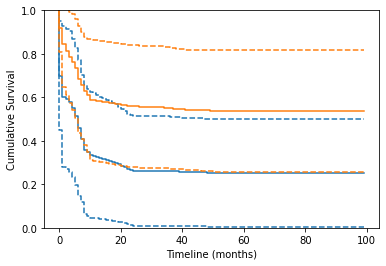

In [ ]:
### ASMA
surv_dict = unfilt_dicts['2yd_no_ASMA']['Normal LR']

fig = km_plots(surv_dict['TSI'], surv_dict['FSI']);

p_m = np.array(surv_dict['Survival_P'])[:,1].mean()
p_std = np.array(surv_dict['Survival_P'])[:,1].std()
fig.savefig('./Prognosis_Paper_Plots/Survival/2yeardeath_no_ASMA.pdf', bbox_inches='tight')

#fig.axes[0].text(0.80, 0.90, f'{p_m:0.7f}', size='x-large', transform=fig.axes[0].transAxes)

# LDA Plots

## 1 year death

In [105]:
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize, FunctionTransformer, OneHotEncoder, MinMaxScaler

In [111]:
numeric_pipe = Pipeline([("Normalise spectra", FunctionTransformer(normalize, kw_args = {"axis": 1})),
("Scaler", MinMaxScaler()),
("PCA", PCA(n_components=8))])

categorical_pipe = Pipeline([
    ("OneHot", OneHotEncoder())
])

in_df = total.reset_index('ASMA').dropna(subset=['ASMA'])#.sample(frac=0.05)
in_df.columns = [str(col) for col in in_df.columns]

ct = make_column_transformer(
    (numeric_pipe,     make_column_selector(dtype_include=np.number)),
    (categorical_pipe, make_column_selector(dtype_include=object))
)

lda_pipe = Pipeline([('CT', ct), ('LDA', LinearDiscriminantAnalysis())])

In [113]:
c = lda_pipe.fit_transform(total_p)

ValueError: No valid specification of the columns. Only a scalar, list or slice of all integers or all strings, or boolean mask is allowed

In [ ]:
total_lda = pd.DataFrame(lda_pipe.fit_transform(in_df, in_df.reset_index()['2year']), index=in_df.index, columns=['LDA_1'])

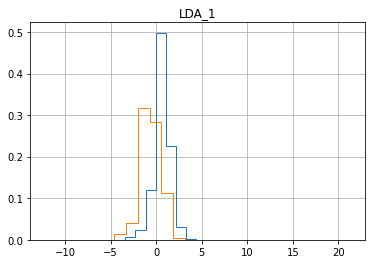

In [ ]:
fig, ax = plt.subplots()

for name, df in total_lda.groupby('2year'):

    df.hist(ax=ax, density=True, histtype='step', bins=20)

# LDA Plots

## 1 year death

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize, FunctionTransformer, OneHotEncoder, MinMaxScaler

In [ ]:
numeric_pipe = Pipeline(["Normalise spectra", FunctionTransformer(normalize, kw_args = {"axis": 1})),
("Scaler", MinMaxScaler()),
("PCA", PCA(npca=8)])

categorical_pipe = Pipeline([
    ("OneHot", OneHotEncoder())
])

in_df = total.reset_total_p('ASMA').dropna(subset=['ASMA'])#.sample(frac=0.05)
in_df.columns = [str(col) for col in in_df.columns]

ct = make_column_transformer(
    (numeric_pipe,     make_column_selector(dtype_include=np.number)),
    (categorical_pipe, make_column_selector(dtype_include=object))
)

lda_pipe = Pipeline([('CT', ct), ('LDA', lda)])

In [ ]:
c = ct.fit_transform(total_p)

ValueError: No valid specification of the columns. Only a scalar, list or slice of all integers or all strings, or boolean mask is allowed

In [ ]:
total_lda = pd.DataFrame(lda_pipe.fit_transform(in_df, in_df.reset_index()['2year']), index=in_df.index, columns=['LDA_1'])

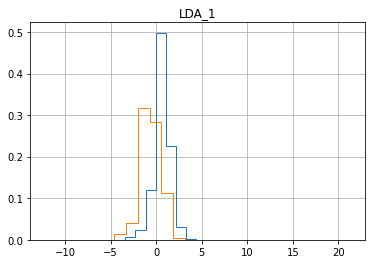

In [ ]:
fig, ax = plt.subplots()

for name, df in total_lda.groupby('2year'):

    df.hist(ax=ax, density=True, histtype='step', bins=20)